In [1]:
print(1)


1


In [2]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from config import *
import re
import numpy as np
import json
import os

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
sys.path.append("../scripts/")

In [4]:
from dataset import load_sara
from eval import jupyter_evaluation
from model import llm_experiment, post_process_split_docs
from models import get_model_version
from preprocess_sara import proccutit


#s = load_sara()
#proc = proccutit(s)
#tokenizer, model = get_model_version('get_mistral', "mistralai/Mistral-7B-Instruct-v0.2", 'main', 'auto')
#jupyter_evaluation(labels, preds)
#llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
#post_process_split_docs(mr, fpr, pre, df)

In [5]:
tokenizer, model = get_model_version('get_l2', "TheBloke/Llama-2-70B-Chat-GPTQ", 'main', 'auto')


tokenizer_config.json: 100%|██████████| 745/745 [00:00<00:00, 288kB/s]
tokenizer.model: 100%|██████████| 500k/500k [00:00<00:00, 25.5MB/s]
tokenizer.json: 100%|██████████| 1.84M/1.84M [00:00<00:00, 4.95MB/s]
config.json: 100%|██████████| 840/840 [00:00<00:00, 583kB/s]
CUDA extension not installed.
CUDA extension not installed.
model.safetensors: 100%|██████████| 35.3G/35.3G [06:39<00:00, 88.4MB/s]
generation_config.json: 100%|██████████| 137/137 [00:00<00:00, 46.6kB/s]


#### Reading results

In [5]:
#os.listdir('../scripts/results')

In [6]:
def get_results_json(file_name):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    target_directory = os.path.join(parent_directory, 'scripts/results')
    #print("Path to results", target_directory)

    #file_name = 'test.json'
    file_path = os.path.join(target_directory, file_name)
    #print(file_path)

    with open(file_path) as json_file:
        data = json.load(json_file)

    df = pd.DataFrame(data)
    #print(df)
    return df

In [7]:
all_results_df = get_results_json('clean_model_responses.json')

In [8]:
results_df = all_results_df[(all_results_df['prompt'] == 'itspersonal') | (all_results_df['prompt'] == 'itspersonal_2') | (all_results_df['prompt'] == 'itspersonalfewshot') | (all_results_df['prompt'] == 'itspersonalsys') | (all_results_df['prompt'] == 'itspersonal_2sys') | (all_results_df['prompt'] == 'itspersonalfewshotsys')]

In [9]:
results_df

,model,prompt,doc_id,prediction,ground_truth
0,mixt-4bit,itspersonal,114715,0,0
1,mixt-4bit,itspersonal,229405,0,0
2,mixt-4bit,itspersonal,232795,0,0
3,mixt-4bit,itspersonal,62815,0,0
4,mixt-4bit,itspersonal,118871,0,0
...,...,...,...,...,...
75074,mixt-4bit,itspersonal_2,98429,0,0
75075,mixt-4bit,itspersonal_2,122436,0,0
75076,mixt-4bit,itspersonal_2,7992,1,0
75077,mixt-4bit,itspersonal_2,122029,0,0


#### Basic Analysis

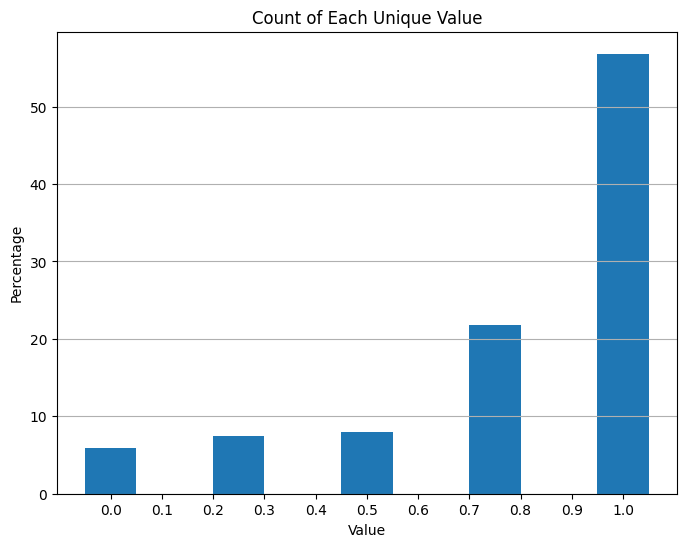

In [10]:
def got_correct(df, prompt):
    doc_percentage_correct = {}

    for d in df.doc_id.unique():
        doc_preds = df[df.doc_id == d]
        doc_preds = doc_preds[doc_preds.prompt == prompt]
        #print(doc_preds)

        # For sensitive docs
        #doc_preds = doc_preds[doc_preds.ground_truth == 0]
        #if len(doc_preds) == 0:
        #    continue

        doc_correct = 0
        for s in doc_preds.iterrows():
            row = s[1]
            if row.prediction == row.ground_truth:
                doc_correct += 1

        doc_correct_avg = doc_correct / len(doc_preds)
        doc_percentage_correct[d] = doc_correct_avg

    return doc_percentage_correct

def plot_correct(data):
    unique_values, counts = np.unique(data, return_counts=True)
    total_count = len(data)
    percentages = (counts / total_count) * 100

    # Bar plot
    plt.figure(figsize=(8, 6))
    plt.bar(unique_values, percentages, width=0.1)
    plt.xlabel('Value')
    plt.ylabel('Percentage')
    plt.title('Count of Each Unique Value')
    plt.xticks(np.arange(0, 1.1, 0.1))  # Set x-ticks to show the range 0.0 - 1.0
    plt.grid(axis='y')
    plt.show()


prompt = 'itspersonal'
doc_percentage_correct = got_correct(results_df, prompt)
plot_correct(list(doc_percentage_correct.values()))

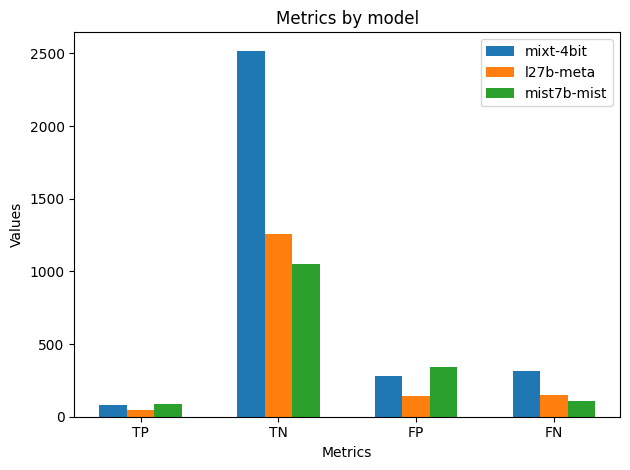

In [11]:
def confusion_scores(df, prompt):
    doc_percentage_correct = {}

    for d in df.model.unique():

        doc_preds = df[df.model == d]
        doc_preds = doc_preds[doc_preds.prompt == prompt]
        TP, TN, FP, FN = 0, 0, 0, 0

        for s in doc_preds.iterrows():
            row = s[1]
            if row.prediction == row.ground_truth and row.ground_truth == 1:
                TP += 1
            elif row.prediction == row.ground_truth and row.ground_truth == 0:
                TN += 1
            elif row.prediction != row.ground_truth and row.ground_truth == 1:
                FN += 1
            else:
                FP += 1

        scores = [TP, TN, FP, FN]
        doc_percentage_correct[d] = scores

    return doc_percentage_correct

def plot_confusion(data):
    data = model_confusion
    labels = ['TP', 'TN', 'FP', 'FN']
    models = list(data.keys())
    values = np.array(list(data.values()))

    # Number of groups and bar width
    n_groups = len(labels)
    bar_width = 0.2

    # Set position of bar on X axis
    r = np.arange(len(labels))
    positions = [r + bar_width*i for i in range(len(models))]

    # Make bars
    for pos, model in zip(positions, models):
        plt.bar(pos, values[models.index(model)], width=bar_width, label=model)

    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Metrics by model')
    plt.xticks([r + bar_width for r in range(n_groups)], labels)
    plt.legend()
    plt.tight_layout()
    plt.show()


prompt = 'itspersonal'
model_confusion = confusion_scores(results_df, prompt)
plot_confusion(model_confusion)

In [12]:
results_df.keys()

Index(['model', 'prompt', 'doc_id', 'prediction', 'ground_truth'], dtype='object')

In [13]:
results_df

,model,prompt,doc_id,prediction,ground_truth
0,mixt-4bit,itspersonal,114715,0,0
1,mixt-4bit,itspersonal,229405,0,0
2,mixt-4bit,itspersonal,232795,0,0
3,mixt-4bit,itspersonal,62815,0,0
4,mixt-4bit,itspersonal,118871,0,0
...,...,...,...,...,...
75074,mixt-4bit,itspersonal_2,98429,0,0
75075,mixt-4bit,itspersonal_2,122436,0,0
75076,mixt-4bit,itspersonal_2,7992,1,0
75077,mixt-4bit,itspersonal_2,122029,0,0


#### Prompt Effectiveness

Prompt performance: How models perform across different prompts

In [40]:
from sklearn.metrics import balanced_accuracy_score, f1_score

def calculate_accuracy(group):
    correct_predictions = (group['prediction'] == group['ground_truth']).sum()
    total_predictions = len(group)
    accuracy = correct_predictions / total_predictions
    return accuracy

def calculate_balanced_accuracy(group):
    return balanced_accuracy_score(group['ground_truth'], group['prediction'])

def calculate_f1(group):
    return f1_score(group['ground_truth'], group['prediction'], average='weighted')

def prompt_performance(df):
    #accuracy_df = results_df.groupby(['model', 'prompt']).apply(lambda x: (x['prediction'] == x['ground_truth']).mean()).reset_index(name='accuracy')
    # Group by model and prompt, then apply the calculation for each metric
    grouped = df.groupby(['model', 'prompt'])
    accuracy_df = grouped.apply(calculate_accuracy).reset_index(name='accuracy')
    balanced_accuracy_df = grouped.apply(calculate_balanced_accuracy).reset_index(name='balanced_accuracy')
    f1_score_df = grouped.apply(calculate_f1).reset_index(name='f1_score')
    # Merge results into a single DataFrame - easy comparison
    performance_df = pd.merge(accuracy_df, balanced_accuracy_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, f1_score_df, on=['model', 'prompt'])
    #print(performance_df)
    return performance_df

prompt_performance_df = prompt_performance(results_df)

In [41]:
prompt_performance_df

,model,prompt,accuracy,balanced_accuracy,f1_score
0,mist7b-mist,b1,0.831258,0.503696,0.801917
1,mist7b-mist,b1_2,0.871715,0.504004,0.819451
2,mist7b-mist,b1_2sys,0.866083,0.500790,0.816476
3,mist7b-mist,b1sys,0.829161,0.505736,0.805690
4,mist7b-mist,b2,0.738885,0.486856,0.757615
5,mist7b-mist,b2_2,0.780213,0.486438,0.778996
6,mist7b-mist,b2_2sys,0.804511,0.489429,0.790838
7,mist7b-mist,b2sys,0.743895,0.483171,0.759743
8,mist7b-mist,fewshotsim,0.359825,0.565263,0.419629
9,mist7b-mist,itspersonal,0.715717,0.601445,0.755702


In [16]:
prev_results_df = all_results_df[(all_results_df['prompt'] == 'b1') | (all_results_df['prompt'] == 'b2') | (all_results_df['prompt'] == 'b1_2') | (all_results_df['prompt'] == 'b2_2') | (all_results_df['prompt'] == 'b1sys') | (all_results_df['prompt'] == 'b2sys') | (all_results_df['prompt'] == 'b1_2sys') | (all_results_df['prompt'] == 'b2_2sys')]
prompt_performance(prev_results_df)

,model,prompt,accuracy,balanced_accuracy,f1_score
0,l27b-meta,b1,0.782690,0.488259,0.776632
1,l27b-meta,b1_2,0.759700,0.485606,0.768147
2,l27b-meta,b1_2sys,0.692115,0.468716,0.727621
3,l27b-meta,b1sys,0.759700,0.474766,0.765976
4,l27b-meta,b2,0.645585,0.433642,0.695250
5,l27b-meta,b2_2,0.559800,0.432694,0.634359
6,l27b-meta,b2_2sys,0.418910,0.433031,0.506877
7,l27b-meta,b2sys,0.604258,0.440604,0.667776
8,mist7b-mist,b1,0.831258,0.503696,0.801917
9,mist7b-mist,b1_2,0.871715,0.504004,0.819451


Interaction effects: we aim to assess interaction effects between models and prompts. An ANOVA (Analysis of Variance) if data meets the is parametric.

#### Incomplete interaction effects

In [12]:
l2_mist = prompt_performance_df
l2_mist = l2_mist.drop([6, 7])
l2_mist

,model,prompt,accuracy,balanced_accuracy
0,l27b-meta,itspersonal,0.782854,0.557359
1,l27b-meta,itspersonal_2,0.799750,0.517136
2,l27b-meta,itspersonalfewshot,0.178348,0.513727
3,mist7b-mist,itspersonal,0.694969,0.592748
4,mist7b-mist,itspersonal_2,0.655542,0.579719
5,mist7b-mist,itspersonalfewshot,0.419900,0.554019


In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


l2_mist['model'] = l2_mist['model'].astype(str)
l2_mist['prompt'] = l2_mist['prompt'].astype(str)
# Model with interaction between 'model' and 'prompt'
model = smf.ols('accuracy ~ model * prompt', data=l2_mist).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 28 Feb 2024   Prob (F-statistic):                nan
Time:                        13:54:59   Log-Likelihood:                 203.58
No. Observations:                   6   AIC:                            -395.2
Df Residuals:                       0   BIC:                            -396.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [14]:
from scipy.stats import kruskal

data1 = l2_mist[l2_mist['model'] == 'l27b-meta']['accuracy']
data2 = l2_mist[l2_mist['model'] == 'mist7b-mist']['accuracy']
#data3 = results_df[results_df['model'] == 'mixt4bit']['accuracy']

# Kruskal-Wallis H Test
stat, p = kruskal(data1, data2) #, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')


Statistics=0.429, p=0.513
Same distributions (fail to reject H0)


#### Document Difficulty

Identify difficult documents to classify. We calculate the misclassification rate for each document across all models and prompts.

We find documents that no model-prompt combination could predict this correctly.

In [18]:
def get_most_difficult_docs(df):
    misclassification_df = df.groupby('doc_id').apply(lambda x: (x['prediction'] != x['ground_truth']).mean()).reset_index(name='misclassification_rate')
    # Sorting finds the documents with the highest misclassification rates
    return misclassification_df.sort_values(by='misclassification_rate', ascending=False)

def get_all_wrong():
    # Documents entirely misclassified
    return most_difficult_docs[most_difficult_docs.misclassification_rate == 1]

most_difficult_docs = get_most_difficult_docs(results_df)
all_wrong = get_all_wrong()


Next, we analyse these errors. We will manually review the documents, their predicted and ground truths.

In [19]:
def get_n_most_difficult_docs(most_difficult_docs, n=10):
    difficult_doc_ids = most_difficult_docs['doc_id'].head(n)
    return difficult_doc_ids

difficult_doc_ids = get_n_most_difficult_docs(most_difficult_docs)

In [20]:
s = load_sara()
diff_id = list(difficult_doc_ids)

id_index = []
for idd in diff_id:
    find = s[s.doc_id == idd]
    id_index.append(find.index[0])

print(id_index)
x = proccutit(s.loc[id_index])
for hard in x.iterrows():
    print(hard[1].text)
    break

[229, 203, 900, 1299, 1176, 1026, 1438, 1394, 893, 1563]
Attached is a brief note on liquidity with references to a couple of surveys which provide further information.  My attempt was to write at a reasonable degree of simplicity while providing a general familiarity with the attendant issues.  Please comment.  Thanks.
Also, Profs. Maureen O'Hara, Lawrence Glosten, Haim Mendelson, Joel Hasbrouck, Hans Stoll, Albert Kyle, Lawerence Harris, and Ananth Madhavan are some of the leading academics in the field.
Rakesh


#### Model Comparison Analysis

We conduct numerous statistical tests.

In [19]:
### Do models vary given different prompts.
### Do prompts vary when used by different models.
### Inter-model agreement



In [20]:
all_results_df = get_results_json('clean_model_responses.json')
results_df = all_results_df[(all_results_df['prompt'] == 'itspersonal') | (all_results_df['prompt'] == 'itspersonal_2') | (all_results_df['prompt'] == 'itspersonalfewshot') | (all_results_df['prompt'] == 'itspersonalsys') | (all_results_df['prompt'] == 'itspersonal_2sys') | (all_results_df['prompt'] == 'itspersonalfewshotsys')]



In [21]:
results_df = results_df.reset_index()

In [22]:
model = 'l27b-meta'
model2 = 'mist7b-mist'
prompt = 'itspersonal'
model_results_df = results_df[(results_df['model'] == model) | (results_df['model'] == model2)]
#model_results_df = model_results_df[(model_results_df['prompt'] == prompt)]


In [23]:
model_results_df

,index,model,prompt,doc_id,prediction,ground_truth
4794,30369,l27b-meta,itspersonal,114715,0,0
4795,30370,l27b-meta,itspersonal,229405,0,0
4796,30371,l27b-meta,itspersonal,232795,0,0
4797,30372,l27b-meta,itspersonal,62815,0,0
4798,30373,l27b-meta,itspersonal,118871,0,0
...,...,...,...,...,...,...
23960,49535,mist7b-mist,itspersonalfewshotsys,232322,0,0
23961,49536,mist7b-mist,itspersonalfewshotsys,175448,0,0
23962,49537,mist7b-mist,itspersonalfewshotsys,175814,1,0
23963,49538,mist7b-mist,itspersonalfewshotsys,175816,1,0


In [24]:
#x = prompt_performance(model_results_df)
#x

In [25]:
from statsmodels.stats.contingency_tables import mcnemar

def run_mcnemar(table):
    result = mcnemar(table, exact=True, correction=True)
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')


def mcnemar_table(control, change, all_ids):
    seen_id = []
    both_correct = 0
    control_cor = 0
    change_cor = 0
    both_incor = 0

    for val in control:
        if val in change:
            both_correct += 1
        else:
            control_cor += 1
        seen_id.append(val)

    for val in change:
        if val in seen_id:
            continue
        else:
            change_cor += 1
        seen_id.append(val)

    
    both_incor = len(all_ids) - (both_correct + control_cor + change_cor)
    table = [[both_correct, control_cor], [change_cor, both_incor]]
    return table


In [26]:
######################
          #
   BOTH   #   ORIG
          #
######################
          #
   NEW    #   WRONG BOTH
          #
######################

IndentationError: unexpected indent (3254802345.py, line 3)

In [ ]:
model_results_df = results_df

In [ ]:
correct_res_df = model_results_df[model_results_df['prediction'] == model_results_df['ground_truth']]
ids = correct_res_df[(correct_res_df.model == 'mist7b-mist') & (correct_res_df.prompt == 'itspersonal')].doc_id.to_list()
ids2 = correct_res_df[(correct_res_df.model == 'mist7b-mist') & (correct_res_df.prompt == 'itspersonalfewshot')].doc_id.to_list()

unique_ids = set(model_results_df.doc_id)
unique_ids_list = list(unique_ids)
table = mcnemar_table(ids, ids2, unique_ids_list)

In [27]:
print(table)
run_mcnemar(table)

NameError: name 'table' is not defined

In [28]:
model_results_df

,index,model,prompt,doc_id,prediction,ground_truth
4794,30369,l27b-meta,itspersonal,114715,0,0
4795,30370,l27b-meta,itspersonal,229405,0,0
4796,30371,l27b-meta,itspersonal,232795,0,0
4797,30372,l27b-meta,itspersonal,62815,0,0
4798,30373,l27b-meta,itspersonal,118871,0,0
...,...,...,...,...,...,...
23960,49535,mist7b-mist,itspersonalfewshotsys,232322,0,0
23961,49536,mist7b-mist,itspersonalfewshotsys,175448,0,0
23962,49537,mist7b-mist,itspersonalfewshotsys,175814,1,0
23963,49538,mist7b-mist,itspersonalfewshotsys,175816,1,0


In [29]:
all_results_df = get_results_json('clean_model_responses.json')
results_df = all_results_df[(all_results_df.model == 'mist7b-mist')]

correct_res_df = results_df[results_df['prediction'] == results_df['ground_truth']]
orig = correct_res_df[correct_res_df.prompt == 'itspersonal'].doc_id.to_list()
pure = correct_res_df[correct_res_df.prompt == 'itspersonalpurelygenres'].doc_id.to_list()

unique_ids = set(model_results_df.doc_id)
unique_ids_list = list(unique_ids)
table = mcnemar_table(orig, pure, unique_ids_list)

table

[[1101, 42], [262, 193]]

#### Classification inspection

In [30]:
# Eval config
model_name = 'mist7b-mist'
prompt_name = 'itspersonal'
truth_lab = 0
model_guess = 1

In [31]:
rdf = model_results_df
rdf_truth_select = rdf[rdf.ground_truth == truth_lab]
mistitspers = rdf_truth_select[(rdf_truth_select.model == model_name) & (rdf_truth_select.prompt == prompt_name)]
model_predguess_ids = mistitspers[mistitspers.prediction == model_guess].doc_id.to_list()

In [32]:
gen_resp_df = get_results_json('all_model_responses.json')
gendf = gen_resp_df[gen_resp_df.ground_truth == truth_lab]
genx = gendf[(gendf.model == model_name) & (gendf.prompt == 'itspersonal')]
genx = gendf[(gendf.model == model_name) & (gendf.prompt == 'itspersonalverbose')]

#genx = cc[cc.prediction == 1]
#genx.set_index('doc_id', inplace=True)


In [33]:
#unique_ids = set(genx.doc_id)
#unique_ids_list = list(unique_ids)
#print(len(unique_ids_list))

In [34]:
# Get most recent row of doc prediction - that is most likely the one I want after rerunning experiments.
#no_preds = len(genx[genx.doc_id == '175816_0'])
#gen_ans = genx[genx.doc_id == '175816_0'].iloc[no_preds-1].generated_response

In [35]:
s = load_sara()
filtered_df = s[s['doc_id'].isin(model_predguess_ids)]
filtered_df = proccutit(filtered_df)
#filtered_df

In [36]:
for i, tex in enumerate(filtered_df.iterrows()):
    idd = tex[1].doc_id
    text = tex[1].text
    sens = tex[1].sensitivity
    try:
        # Get most recent row of doc prediction - that is most likely the one I want after rerunning experiments.
        no_preds = len(genx[genx.doc_id == idd])
        gen_row = genx[genx.doc_id == idd].iloc[no_preds-1]
        gen_ans = gen_row.generated_response
        gen_pred = gen_row.prediction
    except:
        gen_ans = 'Nothing'
        gen_pred = None
    
    print('DOCUMENT VIEW')
    print('Document', idd, 'Class', sens, '\nMessage:')
    print(text)
    print('End Message.')
    print('\nPrediction:', gen_pred, '. Response:', gen_ans)
    print('\n\n')
    
    #if i == 1:
    #    break

DOCUMENT VIEW
Document 114715_0 Class 0 
Message:
Though I had a somewhat different notion when I initially raised the idea of co-sponsorship, I agree with Lee's observations and think that we should proceed the way he suggests.
End Message.

Prediction: 0.0 . Response: [/INST] 
 The text does not contain any overtly personal information. The message is about agreeing with a colleague's suggestion in a professional context. There is no mention of personal matters such as health, family, or emotions. Therefore, based on the provided message, it appears to be a professional communication and does not contain purely personal information.</s>



DOCUMENT VIEW
Document 114715_1 Class 0 
Message:
All,Lee asked me to forward this.  I'm still awaiting additional suggestions fromanyone on speakers.
I guess Lee's e-mail changes things.  If the business school wants to go forwardwith a conference anyway then it may be a bad idea to have a separate one.  Jeffhas said he likes the idea of coordinat

### Main Fine Inspection

In [37]:
all_results_df = get_results_json('clean_model_responses.json')

In [38]:
def mc_eval_util(results_df, prompt_name, prompt_name2):
    correct_res_df = results_df[results_df['prediction'] == results_df['ground_truth']]
    orig = correct_res_df[correct_res_df.prompt == prompt_name].doc_id.to_list()
    pure = correct_res_df[correct_res_df.prompt == prompt_name2].doc_id.to_list()

    unique_ids = set(results_df.doc_id)
    unique_ids_list = list(unique_ids)
    table = mcnemar_table(orig, pure, unique_ids_list)
    return table

def mcnemar_eval(model_name, prompt_name, prompt_name2):
    results_df = all_results_df[(all_results_df.model == model_name)]
    overall_table = mc_eval_util(results_df, prompt_name, prompt_name2)
    non_results_df = results_df[results_df['ground_truth'] == 0]
    non_table = mc_eval_util(non_results_df, prompt_name, prompt_name2)
    sen_results_df = results_df[results_df['ground_truth'] == 1]
    sen_table = mc_eval_util(sen_results_df, prompt_name, prompt_name2)

    print('Overall\t\t Non-sensitive only\t Sensitive only')
    #print(np.matrix(overall_table), end='')
    #print(np.matrix(non_table), end='')

    print(np.matrix(overall_table[0]), '\t', np.matrix(non_table[0]), '\t\t', np.matrix(sen_table[0]))
    print(np.matrix(overall_table[1]), '\t', np.matrix(non_table[1]), '\t\t', np.matrix(sen_table[1]))
    return overall_table

#model_name = 'mist7b-mist'
#prompt_name = 'itspersonal'
#prompt_name2 = 'itspersonalverbosecot'
#table = mcnemar_eval(model_name, prompt_name, prompt_name2)

model_name = 'mist7b-mist'
compare = [('itspersonal','itspersonalpurely'), ('b1', 'itspersonal')]
for v in compare:
    print('Control:', v[0], '\tChange:', v[1])
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, prompt_name, prompt_name2)
    run_mcnemar(overall)


Control: itspersonal 	Change: itspersonalpurely
Overall		 Non-sensitive only	 Sensitive only
[[1078   65]] 	 [[1023   31]] 		 [[55 34]]
[[151 304]] 	 [[148 198]] 		 [[  3 106]]
statistic=65.000, p-value=0.000
Different proportions of errors (reject H0)
Control: b1 	Change: itspersonal
Overall		 Non-sensitive only	 Sensitive only
[[1011  324]] 	 [[1003  319]] 		 [[8 5]]
[[132 131]] 	 [[51 27]] 		 [[ 81 104]]
statistic=132.000, p-value=0.000
Different proportions of errors (reject H0)


In [39]:
# Eval config
model_name = 'mist7b-mist'
prompt_name = 'itspersonalpurely'
truth_lab = 0
model_guess = 1

rdf = results_df
rdf_truth_select = rdf[rdf.ground_truth == truth_lab]
mistitspers = rdf_truth_select[(rdf_truth_select.model == model_name) & (rdf_truth_select.prompt == prompt_name)]
model_predguess_ids = mistitspers[mistitspers.prediction == model_guess].doc_id.to_list()

gen_resp_df = get_results_json('all_model_responses.json')
gendf = gen_resp_df[gen_resp_df.ground_truth == truth_lab]
genx = gendf[(gendf.model == model_name) & (gendf.prompt == prompt_name)]

genverbose = gendf[(gendf.model == model_name) & (gendf.prompt == 'itspersonalverbose')]

s = load_sara()
filtered_df = s[s['doc_id'].isin(model_predguess_ids)]
filtered_df = proccutit(filtered_df)


for i, tex in enumerate(filtered_df.iterrows()):
    idd = tex[1].doc_id
    text = tex[1].text
    sens = tex[1].sensitivity
    try:
        # Get most recent row of doc prediction - that is most likely the one I want after rerunning experiments.
        no_preds = len(genx[genx.doc_id == idd])
        gen_row = genx[genx.doc_id == idd].iloc[no_preds-1]
        gen_ans = gen_row.generated_response
        gen_pred = gen_row.prediction
    except:
        gen_ans = 'Nothing'
        gen_pred = None

    try:
        no_preds = len(genverbose[genverbose.doc_id == idd])
        gen_row = genverbose[genverbose.doc_id == idd].iloc[no_preds-1]
        verb = gen_row.generated_response
    except:
        verb = None    

    print('DOCUMENT VIEW')
    print('Document', idd, 'Class', sens, '\nMessage:')
    print(text)
    print('End Message.')
    print('\nPrediction:', gen_pred, '. Response:', gen_ans)
    print('Verbose desc:', verb)
    print('\n\n')
    
    #if i == 1:
    #    break



DOCUMENT VIEW
Document 114715_0 Class 0 
Message:
Though I had a somewhat different notion when I initially raised the idea of co-sponsorship, I agree with Lee's observations and think that we should proceed the way he suggests.
End Message.

Prediction: 0.0 . Response:  
 The text does not contain any overt
Verbose desc: [/INST] 
 The text does not contain any overtly personal information. The message is about agreeing with a colleague's suggestion in a professional context. There is no mention of personal matters such as health, family, or emotions. Therefore, based on the provided message, it appears to be a professional communication and does not contain purely personal information.</s>



DOCUMENT VIEW
Document 114715_1 Class 0 
Message:
All,Lee asked me to forward this.  I'm still awaiting additional suggestions fromanyone on speakers.
I guess Lee's e-mail changes things.  If the business school wants to go forwardwith a conference anyway then it may be a bad idea to have a separ

In [95]:
# Eval config
model_name = 'mist7b-mist'
prompt_name_control = 'itspersonal'
prompt_name_change = 'itspersonalpurely'
truth_lab = 0
model_guess = 1

rdf = results_df
rdf_truth_select = rdf[rdf.ground_truth == truth_lab]
df = rdf_truth_select[(rdf_truth_select.model == model_name) & ((rdf_truth_select.prompt == prompt_name_control) |  (rdf_truth_select.prompt == prompt_name_change))]
guess_df = df[df.prediction == model_guess] #.doc_id.to_list()
diff_guess_df = guess_df.groupby('doc_id').filter(lambda x: x['prompt'].nunique() == 1)
#print(len(diff_guess_df))
id_diff_guesses = diff_guess_df.doc_id.to_list()
#print(id_diff_guesses)

#print(df[df.doc_id == id_diff_guesses[0]])

gen_resp_df = get_results_json('all_model_responses.json')
gendf = gen_resp_df[gen_resp_df.ground_truth == truth_lab]
genx = gendf[(gendf.model == model_name) & ((gendf.prompt == prompt_name_control) | (gendf.prompt == prompt_name_change) )]

genverbose = gendf[(gendf.model == model_name) & (gendf.prompt == 'itspersonalverbose')]

s = load_sara()
filtered_df = s[s['doc_id'].isin(id_diff_guesses)]
filtered_df = proccutit(filtered_df)


for i, tex in enumerate(filtered_df.iterrows()):
    idd = tex[1].doc_id
    text = tex[1].text
    sens = tex[1].sensitivity
    try:
        # Get most recent row of doc prediction - that is most likely the one I want after rerunning experiments.
        no_preds = len(genx[genx.doc_id == idd])
        all_rows_control = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_control)]
        all_rows_change = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_change)]
        gen_row_control = all_rows_control.iloc[len(all_rows_control)-1]
        gen_ans_control = gen_row_control.generated_response
        gen_pred_control = gen_row_control.prediction
        gen_row_change = all_rows_change.iloc[len(all_rows_change)-1]
        gen_ans_change = gen_row_change.generated_response
        gen_pred_change = gen_row_change.prediction
    except:
        gen_ans_control = 'Nothing'
        gen_pred_control = None
        gen_ans_change = 'Nothing'
        gen_pred_change = None

    try:
        no_preds = len(genverbose[genverbose.doc_id == idd])
        gen_row = genverbose[genverbose.doc_id == idd].iloc[no_preds-1]
        verb = gen_row.generated_response
    except:
        verb = None

    if gen_pred_change == truth_lab:
        continue

    print('DOCUMENT VIEW')
    print('Document', idd, 'Class', sens, '\nMessage:')
    print(text)
    print('End Message.')
    print('\nCONTROL: Prediction:', gen_pred_control, '. Response:', gen_ans_control)
    print('\nCHANGE: Prediction:', gen_pred_change, '. Response:', gen_ans_change)
    print('Verbose desc:', verb)
    print('\n\n')
    
    #if i == 4:
    #    break



DOCUMENT VIEW
Document 176514_2 Class 0 
Message:
Subject: Public Policy Contacts for California
Jeff and  SteveAs you requested, I have  prepared a list of my preferred public policy contacts?for  California.? It is composed of professionals from an array of public,  private and non-profit backgrounds.? I have worked in some capacity  with?each of these people?and most I know quite well.?  Please call me for further  background.Kevin213-926-2626Attachment - Kevin Scott -  Preferred Contacts - 6-20-01.doc
End Message.

CONTROL: Prediction: 1.0 . Response: [/INST] 
 The text does contain personal information, specifically the names and contact information

CHANGE: Prediction: nan . Response:  
 The text does mention some personal names (
Verbose desc: [/INST] 
 The text does contain personal information, but it is in a professional context. The message is about sharing a list of preferred public policy contacts for California, and the sender has worked with each of these individuals and